# Import

In [1]:
!pip install torchsummaryX

In [98]:
import torch
import numpy as np
import torch.nn as nn
from torchsummaryX import summary
from tqdm import tqdm
import pandas as pd
from scipy import stats
import joypy
import matplotlib.pyplot as plt

import pickle

from sklearn.model_selection import train_test_split


# Constants

In [99]:
num_quantiles = 11 # H_in
look_back_window = 5 # L
hidden_size = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Data

In [4]:
data = np.load('./noisepage-forecast/param_training_data.npz', allow_pickle=True)
X = data["X"]
Y = data["Y"]
# Split into train test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=False, test_size=0.1)
print(X.dtype, X_train.dtype)

# X: (N, L, H_in) to (L, N, H_in);
X_train, X_test = np.transpose(X_train, (1, 0, 2)), np.transpose(X_test, (1, 0, 2))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

float64 float64
(5, 2997, 11) (5, 333, 11) (2997, 11) (333, 11)


In [5]:
with open('../data/query_to_df_map.pickle', 'rb') as f:
  query_to_df_map = pickle.load(f)

with open('../data/query_to_dtype_map.pickle', 'rb') as f:
  query_to_dtype_map = pickle.load(f)

with open('../data/query_to_stats.pickle', 'rb') as f:
  query_to_stats = pickle.load(f)


# Model

In [6]:
from torch.nn.modules import dropout
class Network(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers=4): # You can add any extra arguments as you wish

        super(Network, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, dropout=0.1)
        self.classification = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=64, out_features=output_size)
        )

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        # output: (L, 1 * H_out)

        out = self.classification(output)
        return out

model = Network(num_quantiles, num_quantiles, hidden_size).to(device)
summary(model, torch.tensor(X_train[:, :1, :]).to(device).float())

                             Kernel Shape Output Shape     Params  Mult-Adds
Layer                                                                       
0_lstm                                  -  [5, 1, 256]  1.854464M  1.846272M
1_classification.Linear_0       [256, 64]   [5, 1, 64]    16.448k    16.384k
2_classification.LeakyReLU_1            -   [5, 1, 64]          -          -
3_classification.Dropout_2              -   [5, 1, 64]          -          -
4_classification.Linear_3        [64, 11]   [5, 1, 11]      715.0      704.0
----------------------------------------------------------------------------
                         Totals
Total params          1.871627M
Trainable params      1.871627M
Non-trainable params        0.0
Mult-Adds              1.86336M


/Users/jackiedong/opt/anaconda3/envs/db/lib/python3.7/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[5, 1, 256]",1854464.0,1846272.0
1_classification.Linear_0,"[256, 64]","[5, 1, 64]",16448.0,16384.0
2_classification.LeakyReLU_1,-,"[5, 1, 64]",NaN,NaN
3_classification.Dropout_2,-,"[5, 1, 64]",NaN,NaN
4_classification.Linear_3,"[64, 11]","[5, 1, 11]",715.0,704.0


# Model Parameters

In [33]:
epochs = 50
lr = 0.0001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(X_train.shape[1] * epochs))

# Model Training

In [ ]:
from torch.nn.modules import dropout
class Network(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers=4): # You can add any extra arguments as you wish

        super(Network, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, dropout=0.1)
        self.classification = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=64, out_features=output_size)
        )

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        # output: (L, 1 * H_out)

        out = self.classification(output)
        return out

model = Network(num_quantiles, num_quantiles, hidden_size).to(device)
summary(model, torch.tensor(X_train[:, :1, :]).to(device).float())

In [34]:
for epoch in range(epochs):
    model.train()
    arr = np.arange(X_train.shape[1])
    np.random.shuffle(arr)
    train_loss = 0
    batch_bar = tqdm(total=X_train.shape[1], dynamic_ncols=True, leave=False, position=0, desc='Train') 
    for ind in arr:
        seq = torch.tensor(X_train[:, ind:ind+1, :]).to(device).float()
        labels = torch.tensor(y_train[ind]).to(device).float()
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred[-1, -1, :], labels)
        single_loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += float(single_loss)

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(train_loss / (ind + 1))),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()

    train_loss /= X_train.shape[1]
    batch_bar.close()
    
    # Validation loss
    model.eval()
    val_loss = 0
    batch_bar = tqdm(total=X_train.shape[1], dynamic_ncols=True, leave=False, position=0, desc='Train') 
    for ind in range(X_test.shape[1]):
        seq = torch.tensor(X_test[:, ind:ind+1, :]).to(device).float()
        labels = torch.tensor(y_test[ind]).to(device).float()

        with torch.no_grad():
            y_pred = model(seq)

        single_loss = loss_function(y_pred[-1, -1, :], labels)
        val_loss += float(single_loss)
        batch_bar.update()
    val_loss /= X_test.shape[1]
    batch_bar.close()

    print(f"[LSTM FIT]epoch: {epoch + 1:3}, train_loss: {train_loss:10.8f}, val_loss: {val_loss:10.8f}")

[LSTM FIT]epoch:   1, train_loss: 0.21282222, val_loss: 0.06435927


[LSTM FIT]epoch:   2, train_loss: 0.08292175, val_loss: 0.06323655


[LSTM FIT]epoch:   3, train_loss: 0.05967464, val_loss: 0.05333335


[LSTM FIT]epoch:   4, train_loss: 0.05137001, val_loss: 0.05697150


[LSTM FIT]epoch:   5, train_loss: 0.04723982, val_loss: 0.05132094


[LSTM FIT]epoch:   6, train_loss: 0.04646061, val_loss: 0.03813059


[LSTM FIT]epoch:   7, train_loss: 0.04246991, val_loss: 0.03704227


[LSTM FIT]epoch:   8, train_loss: 0.04032379, val_loss: 0.03227301


[LSTM FIT]epoch:   9, train_loss: 0.03644551, val_loss: 0.03087842


[LSTM FIT]epoch:  10, train_loss: 0.03364679, val_loss: 0.03125820


[LSTM FIT]epoch:  11, train_loss: 0.03156274, val_loss: 0.03042330


[LSTM FIT]epoch:  12, train_loss: 0.02908652, val_loss: 0.02615374


[LSTM FIT]epoch:  13, train_loss: 0.02625521, val_loss: 0.01838885


[LSTM FIT]epoch:  14, train_loss: 0.02549731, val_loss: 0.01821230


[LSTM FIT]epoch:  15, train_loss: 0.02374547, val_loss: 0.01888895


[LSTM FIT]epoch:  16, train_loss: 0.02300062, val_loss: 0.01559864


[LSTM FIT]epoch:  17, train_loss: 0.02202054, val_loss: 0.01548629


[LSTM FIT]epoch:  18, train_loss: 0.02148325, val_loss: 0.01583378


[LSTM FIT]epoch:  19, train_loss: 0.02059241, val_loss: 0.01596718


[LSTM FIT]epoch:  20, train_loss: 0.01907448, val_loss: 0.01566952


[LSTM FIT]epoch:  21, train_loss: 0.01828477, val_loss: 0.01467914


[LSTM FIT]epoch:  22, train_loss: 0.01774809, val_loss: 0.01439236


[LSTM FIT]epoch:  23, train_loss: 0.01718320, val_loss: 0.01779398


[LSTM FIT]epoch:  24, train_loss: 0.01658799, val_loss: 0.01519581


[LSTM FIT]epoch:  25, train_loss: 0.01616242, val_loss: 0.01392716


[LSTM FIT]epoch:  26, train_loss: 0.01610340, val_loss: 0.01665313


[LSTM FIT]epoch:  27, train_loss: 0.01590707, val_loss: 0.01627752


[LSTM FIT]epoch:  28, train_loss: 0.01586049, val_loss: 0.02019108


[LSTM FIT]epoch:  29, train_loss: 0.01522773, val_loss: 0.01568173


[LSTM FIT]epoch:  30, train_loss: 0.01549775, val_loss: 0.01805028


[LSTM FIT]epoch:  31, train_loss: 0.01533757, val_loss: 0.01396925


[LSTM FIT]epoch:  32, train_loss: 0.01534537, val_loss: 0.01571737


[LSTM FIT]epoch:  33, train_loss: 0.01478973, val_loss: 0.01484349


[LSTM FIT]epoch:  34, train_loss: 0.01477768, val_loss: 0.01478660


[LSTM FIT]epoch:  35, train_loss: 0.01456593, val_loss: 0.01611826


[LSTM FIT]epoch:  36, train_loss: 0.01423801, val_loss: 0.01788942


[LSTM FIT]epoch:  37, train_loss: 0.01356895, val_loss: 0.01800509


[LSTM FIT]epoch:  38, train_loss: 0.01430407, val_loss: 0.01609210


[LSTM FIT]epoch:  39, train_loss: 0.01416841, val_loss: 0.01660375


[LSTM FIT]epoch:  40, train_loss: 0.01428562, val_loss: 0.01749764


[LSTM FIT]epoch:  41, train_loss: 0.01366815, val_loss: 0.01642896


[LSTM FIT]epoch:  42, train_loss: 0.01314628, val_loss: 0.01645116


[LSTM FIT]epoch:  43, train_loss: 0.01385140, val_loss: 0.01578493


[LSTM FIT]epoch:  44, train_loss: 0.01378404, val_loss: 0.01590863


[LSTM FIT]epoch:  45, train_loss: 0.01357665, val_loss: 0.01562941


Train:  13%|█▎        | 403/2997 [00:06<00:42, 60.63it/s, loss=0.0030, lr=0.0000]

KeyboardInterrupt: ignored

In [38]:
import os
def save_checkpoint(ckpt_path, id, model, epoch, optimizer, scheduler):
    path = os.path.join(ckpt_path, f"{id}_{epoch}")

    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)

    save_dict = {'model_state': model.state_dict(),
                'epoch': epoch,
                 'id': id,
                 }

    if optimizer != None:
      save_dict['optimizer_state'] = optimizer.state_dict()
    if scheduler != None:
      save_dict['scheduler_state'] = scheduler.state_dict()

    torch.save(save_dict, path)
    print(f"=> saved the model {id} to {path}")

In [36]:
save_checkpoint("./", "model", model, epochs, optimizer, scheduler)

=> saved the model model to ./noisepage_forecast/model_50


In [37]:
from google.colab import files
files.download('./model') 

FileNotFoundError: ignored

# Param Prediction

In [7]:
# Each interval (time step) is vectorized into 4 bins --> [20, 40, 60, 80] percentiles
def left_boundary(x):
  return x.quantile(0.01)
def q1(x):
  return x.quantile(0.1)
def q2(x):
  return x.quantile(0.2)
def q3(x):
  return x.quantile(0.3)
def q4(x):
  return x.quantile(0.4)
def q5(x):
  return x.quantile(0.5)
def q6(x):
  return x.quantile(0.6)
def q7(x):
  return x.quantile(0.7)
def q8(x):
  return x.quantile(0.8)
def q9(x):
  return x.quantile(0.9)
def right_boundary(x):
  return x.quantile(0.99)

# quantiles = [q1, q2, q3, q4, q5, q6, q7, q8, q9]
quantiles = [left_boundary, q1, q2, q3, q4, q5, q6, q7, q8, q9, right_boundary]
quantile_names = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Prediction interval hyperparameters
prediction_interval = pd.Timedelta("2S") # Each interval has two seconds
prediction_seq_len = 5 # 5 data points
prediction_horizon = pd.Timedelta("2S")
# total time = interval * seq_len

In [19]:
query_to_df_map["DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3"].index.max()

Timestamp('2022-03-08 11:29:03.403000-0500', tz='pytz.FixedOffset(-300)')

In [91]:
# Get all parameters for a query and compare it with actual data
def get_all_parameters_for(query_template:str):
  template_df = query_to_df_map[query_template]
  template_dtypes = query_to_dtype_map[query_template]
  template_stats = query_to_stats[query_template]

  for i, col in enumerate(template_df):
    print(f"Processing parameter {i+1}...")
    # Skip non-numerical columns
    if template_dtypes[i] == "string":
      continue

    # Group by pred_iterval and get quantile data
    time_series_df = template_df[col].resample(prediction_interval).agg(quantiles)
    time_series_df = time_series_df.astype(float)

    # Get number of queries in each time interval
    num_template_df = template_df[col].resample(prediction_interval).count()
    # display(num_template_df.head())
    # display(time_series_df.head(10))

    # Build a new dataframe contains predicted parameters for all timestamps
    generated_params = []
    timestamps = []
    for j in tqdm(range(len(time_series_df)-1)):
      # Generate sequence data. Add padding if neccesary
      if j+1 >= prediction_seq_len:
        start_time = j - prediction_seq_len + 1
        seq = time_series_df.iloc[start_time:(j+1),:].to_numpy()
      else:
        seq = time_series_df.iloc[:(j+1),:].to_numpy()
        seq = np.pad(seq, ((prediction_seq_len-j-1, 0), (0, 0)))
      
      # Get predicted quantiles from the model
      seq = seq[None, :, :]
      seq = np.transpose(seq, (1, 0, 2))
      seq = torch.tensor(seq).to(device).float()
      with torch.no_grad():
            pred = model(seq)

      # Ensure prediction quantile values are strictly increasing
      pred = pred[-1, -1, :]
      pred = torch.cummax(pred, dim=0).values

      # Generate num_template samples according to the distribution defined by the predicted quantile values
      pred = pred.cpu().detach().numpy()
      # print("pred:", pred)
      # print("actual:", time_series_df.iloc[j+1, :].to_numpy())
      # mean, std = template_stats[i]
      # pred = pred*std + mean
      class Dist(stats.rv_continuous):
          def _cdf(self, x):
            conditions = [x<=pred[0]]
            for k in range(pred.shape[0]-1):
                conditions.append(pred[k]<=x<=pred[k+1])
            choices = [quantile_name/100 for quantile_name in quantile_names]
            return np.select(conditions, choices, default=0)

      dist = Dist(a=pred[0], b=pred[-1], name="deterministic")
      # Model takes in sequence data until time j and ouputs prediction value for time j+1.
      # Therefore we need the number of queries in thej+1's interval
      num_templates = int(num_template_df[j+1]/10)
      for _ in range(num_templates):
        generated_params.append(dist.rvs()) # Divide by 10 so it runs faster
        timestamps.append(num_template_df.index[j+1])
    predicted_params_df = pd.DataFrame(generated_params, index=timestamps)

    # Print Actual and Predicted results
    print(f"PARAM ${i+1} Predicted")
    joypy.joyplot(predicted_params_df.groupby(pd.Grouper(freq="5s")), hist=True, bins=20, overlap=0, grid=True)
    plt.show()

    print(f"PARAM ${i+1} Actual")
    joypy.joyplot(template_df[col].to_frame().groupby(pd.Grouper(freq="5s")), hist=True, bins=20, overlap=0, grid=True)
    plt.show()
    print("\n")

      



Processing parameter 1...


100%|██████████| 29/29 [00:08<00:00,  3.49it/s]


PARAM $1 Predicted


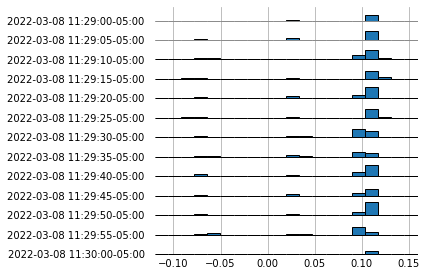

PARAM $1 Actual


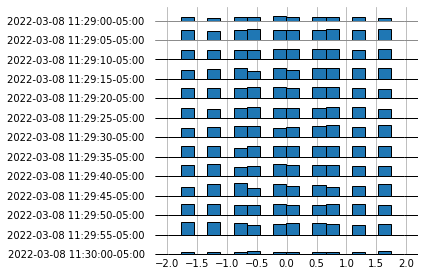



Processing parameter 2...


100%|██████████| 29/29 [00:09<00:00,  3.15it/s]


PARAM $2 Predicted


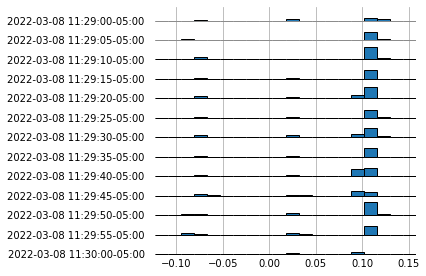

PARAM $2 Actual


/Users/jackiedong/opt/anaconda3/envs/db/lib/python3.7/site-packages/joypy/joyplot.py:57: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  ax.set_xlim([min(x_range), max(x_range)])


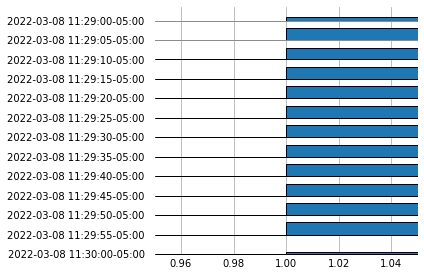



Processing parameter 3...


100%|██████████| 29/29 [00:08<00:00,  3.30it/s]


PARAM $3 Predicted


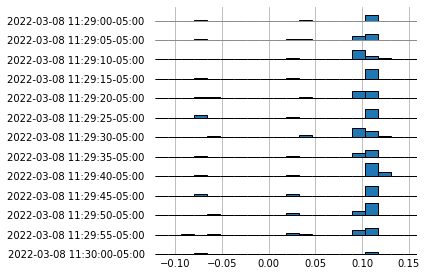

PARAM $3 Actual


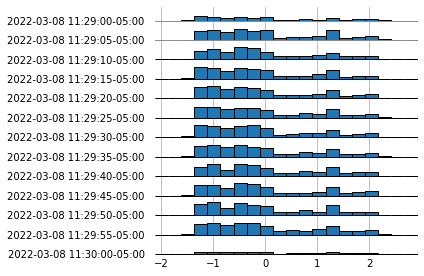



Processing parameter 4...


100%|██████████| 29/29 [00:08<00:00,  3.50it/s]


PARAM $4 Predicted


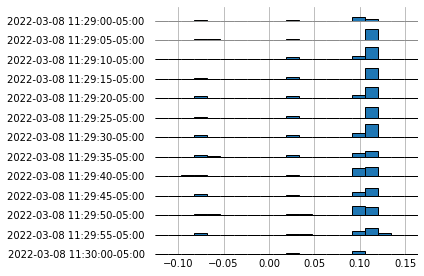

PARAM $4 Actual


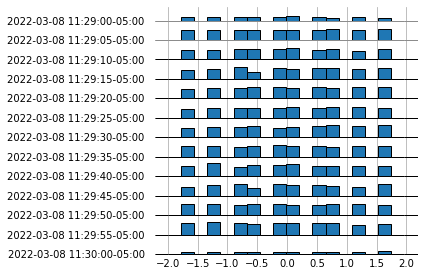



Processing parameter 5...


100%|██████████| 29/29 [00:08<00:00,  3.46it/s]


PARAM $5 Predicted


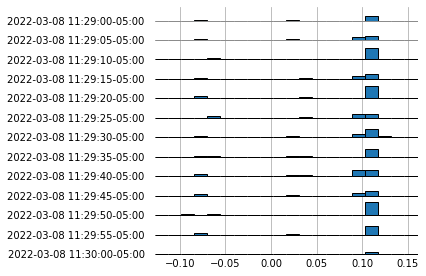

PARAM $5 Actual


/Users/jackiedong/opt/anaconda3/envs/db/lib/python3.7/site-packages/joypy/joyplot.py:57: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  ax.set_xlim([min(x_range), max(x_range)])


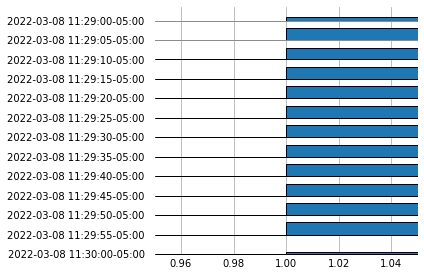



Processing parameter 6...


100%|██████████| 29/29 [00:07<00:00,  3.67it/s]


PARAM $6 Predicted


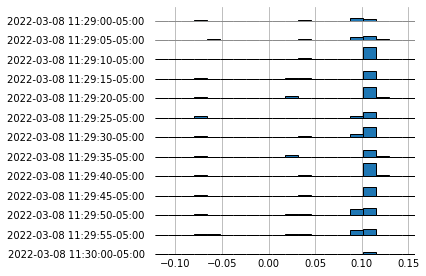

PARAM $6 Actual


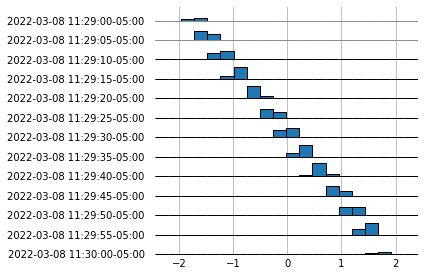



Processing parameter 7...


 90%|████████▉ | 26/29 [00:08<00:00,  3.13it/s]


KeyboardInterrupt: 

In [92]:
get_all_parameters_for("INSERT INTO history (H_C_D_ID, H_C_W_ID, H_C_ID, H_D_ID, H_W_ID, H_DATE, H_AMOUNT, H_DATA) VALUES ($1,$2,$3,$4,$5,$6,$7,$8)")